### LSTM Model

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people. They work tremendously well on a large variety of problems – including also timeseries forecast -, and are now widely used. There is an excellent article explaining [LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series

In [2]:
apple_close_price = get_apple_close_price()

We need to first train/test split, then transform and scale our data

In [3]:
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [4]:
train, test = train_test_split(apple_close_price, 
                               test_size=0.05, 
                               shuffle=False)

In [5]:
boxcox_series, lmbda = boxcox(train.values)

In [6]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()

In [9]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [10]:
# Model parameters
look_back = 3 # days back, same as our ARIMA model, AR(3)
n_features = 1
batch_size = 32
n_epochs = 200

In [11]:
X_train, y_train = split_sequence(scaled_train, look_back)
X_test, y_test = split_sequence(scaled_test, look_back)

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


Let's build a very simple one single LSTM layer network as a benchmark

In [13]:
def build_vanilla_LSTM():
    model = Sequential()

    model.add(LSTM(50, input_shape=(look_back, n_features)))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [14]:
LSTMmodel = build_vanilla_LSTM()

In [15]:
LSTMmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = LSTMmodel.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/200
9211/9211 [==============================] - 3s 371us/step - loss: 0.0029
Epoch 2/200
9211/9211 [==============================] - 2s 238us/step - loss: 0.0014
Epoch 3/200
9211/9211 [==============================] - 2s 244us/step - loss: 6.0512e-04
Epoch 4/200
9211/9211 [==============================] - 2s 240us/step - loss: 2.5044e-04
Epoch 5/200
9211/9211 [==============================] - 2s 247us/step - loss: 1.0579e-04
Epoch 6/200
9211/9211 [==============================] - 2s 242us/step - loss: 7.9791e-05
Epoch 7/200
9211/9211 [==============================] - 2s 240us/step - loss: 8.0492e-05
Epoch 8/200
9211/9211 [==============================] - 2s 245us/step - loss: 9.2114e-05
Epoch 9/200
9211/9211 [==============================] - 2s 240us/step - loss: 1.1979e-04
Epoch 10/200
9211/9211 [==============================] - 2s 247us/step - loss: 1.7848e-04
Epoch 11/200
9211/9211 [==============================] - 2s 244us/step - loss: 2.8481e-04
Epoch 12/200
921

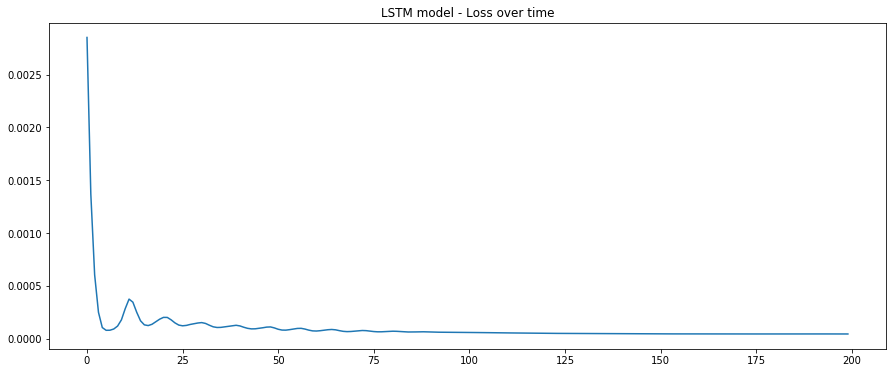

In [17]:
plot_series(history.history['loss'], title='LSTM model - Loss over time')

In [18]:
# walk-forward validation
def LSTM_walk_forward(model, X, y, size=1, debug=True):
    predictions = list()
    limit_range = len(X[:size])

    for t in range(0, limit_range):
        x_input = X[t]
        x_input = x_input.reshape(1, x_input.shape[0], x_input.shape[1])
        y_output = model.predict(x_input)
        predicted = y_output.reshape(1,)
        expected = y[t:t+1].reshape(1,)
        
        predictions.append(predicted)
        
        if debug == True:
            print('predicted={}, expected={}'.format(predicted, expected))
            
    return np.array(predictions)

In [19]:
size = 21 # (approx. one month) and 1 day prediction by default
predictions = LSTM_walk_forward(LSTMmodel, X_test, y_test, size=size)

predicted=[0.99569], expected=[0.9951949]
predicted=[0.99595857], expected=[0.99497687]
predicted=[0.9956747], expected=[0.99522417]
predicted=[0.99592173], expected=[0.9946522]
predicted=[0.9953785], expected=[0.99526179]
predicted=[0.99598086], expected=[0.99562803]
predicted=[0.9962094], expected=[0.99582251]
predicted=[0.99641037], expected=[0.99590915]
predicted=[0.99650645], expected=[0.99673873]
predicted=[0.99725115], expected=[0.99725055]
predicted=[0.9976522], expected=[0.99745855]
predicted=[0.9978745], expected=[0.99766565]
predicted=[0.9980892], expected=[0.99803776]
predicted=[0.998422], expected=[0.99776886]
predicted=[0.99817693], expected=[0.99774109]
predicted=[0.99820507], expected=[0.99845783]
predicted=[0.9988158], expected=[0.99871123]
predicted=[0.9989861], expected=[0.99899035]
predicted=[0.9992795], expected=[0.99785602]
predicted=[0.998281], expected=[0.99743459]
predicted=[0.99801433], expected=[0.99712612]


We need to revert the scaling and transformation:

In [20]:
def revert_transformations(test, predictions):
    original_y_test = scaler.inverse_transform(test)
    original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    original_y_test = inv_boxcox(original_y_test, lmbda)
    original_predictions = inv_boxcox(original_predictions, lmbda)
    
    return original_y_test, original_predictions

In [21]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)

In [22]:
from utils import rmse, plot_walk_forward_validation

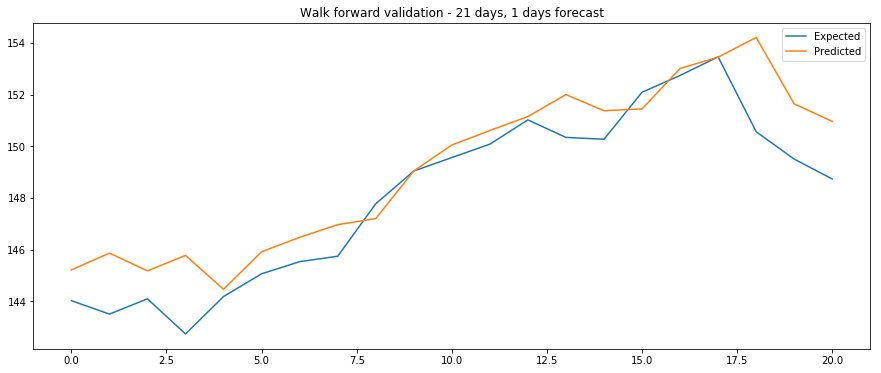

In [23]:
plot_walk_forward_validation(original_y_test, original_predictions, size)

In [24]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, 1, rmse(original_predictions, original_y_test[:size])))

LSTM[21 days, 1 day forecast] - RMSE: 1.524


For multiple steps, I'm gonna use [Recursive Multi-step Forecast](https://machinelearningmastery.com/multi-step-time-series-forecasting/) strategy, but there are better ones, although it's not the purpose to optimize this benchmark

In [25]:
# walk-forward validation by looping over the steps
def LSTM_walk_forward_by_looping(model, X, y, size=1, steps=1, debug=True):
    predictions = list()
    limit_range = len(X[:size])
    look_back = X[0].shape[0]
    n_features = X[0].shape[1]

    for t in range(0, limit_range, steps):
        x_input = X[t]
        x_input = x_input.reshape(1, look_back, n_features)
        
        step_predictions = []
        
        for p in range(steps):
            y_output = model.predict(x_input)
            
            # save the prediction in the sequence
            out_val = y_output.item(0)
            step_predictions.append(out_val)
            
            # get rid of the first price
            in_vals = x_input.flatten()[1:]
            
            # appends the new predicted one
            in_vals = np.append(in_vals, out_val)
            
            # reshape for the next prediction
            x_input = in_vals.reshape(1, look_back, n_features)
            
        predicted = np.array(step_predictions).reshape(steps,)
        expected = y[t:t+steps].reshape(steps,)
        
        predictions.append(predicted)
        
        if debug == True:
            print('predicted={}, expected={}'.format(predicted, expected))
            
    return np.array(predictions)

In [26]:
size = 21 # (approx. one month)
steps = 3 # 3 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.99568999 0.9963963  0.99689424], expected=[0.9951949  0.99497687 0.99522417]
predicted=[0.99592173 0.99650109 0.99698603], expected=[0.9946522  0.99526179 0.99562803]
predicted=[0.99620938 0.9967525  0.99722433], expected=[0.99582251 0.99590915 0.99673873]
predicted=[0.99725115 0.99765265 0.99804616], expected=[0.99725055 0.99745855 0.99766565]
predicted=[0.99808919 0.99846756 0.99879038], expected=[0.99803776 0.99776886 0.99774109]
predicted=[0.99820507 0.9985925  0.99889934], expected=[0.99845783 0.99871123 0.99899035]
predicted=[0.9992795  0.99953794 0.99977076], expected=[0.99785602 0.99743459 0.99712612]


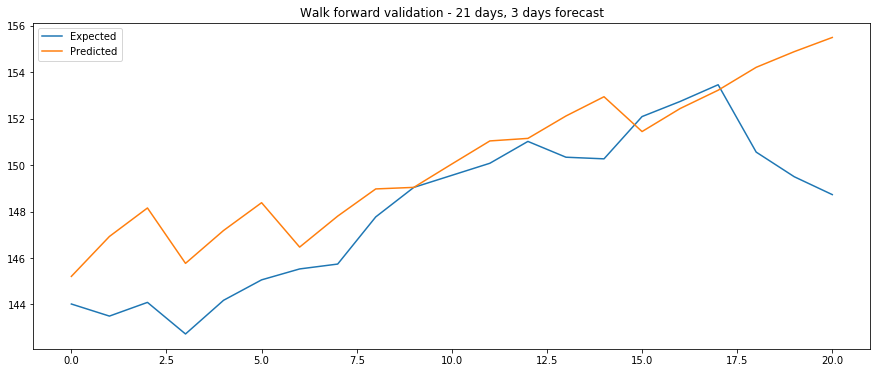

In [27]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [28]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[21 days, 3 day forecast] - RMSE: 2.809


In [29]:
size = 21 # approx. one month
steps = 7 # 7 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.99568999 0.9963963  0.99689424 0.99734187 0.9977659  0.99815381
 0.9985069 ], expected=[0.9951949  0.99497687 0.99522417 0.9946522  0.99526179 0.99562803
 0.99582251]
predicted=[0.99641037 0.99694955 0.99740171 0.99781609 0.99819887 0.99854851
 0.99886763], expected=[0.99590915 0.99673873 0.99725055 0.99745855 0.99766565 0.99803776
 0.99776886]
predicted=[0.99817693 0.99859011 0.99890172 0.99918437 0.99944925 0.99969137
 0.99991179], expected=[0.99774109 0.99845783 0.99871123 0.99899035 0.99785602 0.99743459
 0.99712612]


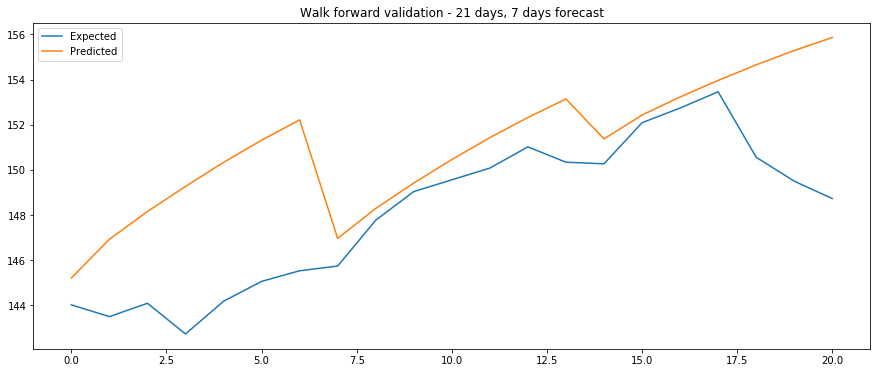

In [30]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [31]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[21 days, 7 day forecast] - RMSE: 3.850


In [32]:
size = 21 # approx. one month
steps = 21 # 21 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.99568999 0.9963963  0.99689424 0.99734187 0.9977659  0.99815381
 0.9985069  0.99882948 0.99912453 0.99939406 0.99964035 0.99986529
 1.00007069 1.00025833 1.00042987 1.00058651 1.00072956 1.00086021
 1.00097954 1.0010885  1.00118804], expected=[0.9951949  0.99497687 0.99522417 0.9946522  0.99526179 0.99562803
 0.99582251 0.99590915 0.99673873 0.99725055 0.99745855 0.99766565
 0.99803776 0.99776886 0.99774109 0.99845783 0.99871123 0.99899035
 0.99785602 0.99743459 0.99712612]


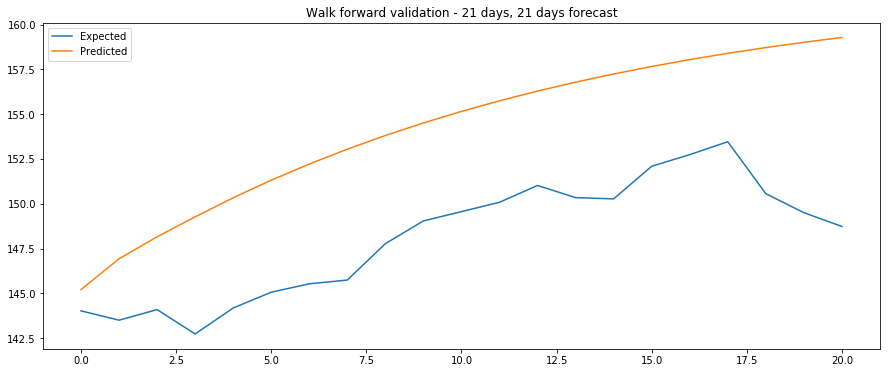

In [33]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [34]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[21 days, 21 day forecast] - RMSE: 6.350


In [35]:
size = 42 # approx. two months
steps = 42 # 42 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.99568999 0.9963963  0.99689424 0.99734187 0.9977659  0.99815381
 0.9985069  0.99882948 0.99912453 0.99939406 0.99964035 0.99986529
 1.00007069 1.00025833 1.00042987 1.00058651 1.00072956 1.00086021
 1.00097954 1.0010885  1.00118804 1.00127876 1.00136173 1.00143754
 1.00150681 1.00156999 1.00162768 1.00168049 1.00172853 1.0017724
 1.00181246 1.00184906 1.00188243 1.00191295 1.00194085 1.00196612
 1.00198936 1.00201058 1.0020299  1.00204766 1.00206375 1.00207853], expected=[0.9951949  0.99497687 0.99522417 0.9946522  0.99526179 0.99562803
 0.99582251 0.99590915 0.99673873 0.99725055 0.99745855 0.99766565
 0.99803776 0.99776886 0.99774109 0.99845783 0.99871123 0.99899035
 0.99785602 0.99743459 0.99712612 0.99765372 1.00039191 0.99979902
 1.00010961 1.00101453 1.00148258 1.00184061 0.99970392 1.00051934
 1.00139816 1.00203673 1.00180055 1.00066135 1.00052683 1.00041818
 1.00137244 1.00144589 1.0011846  1.00140184 1.00198959 1.00250913]


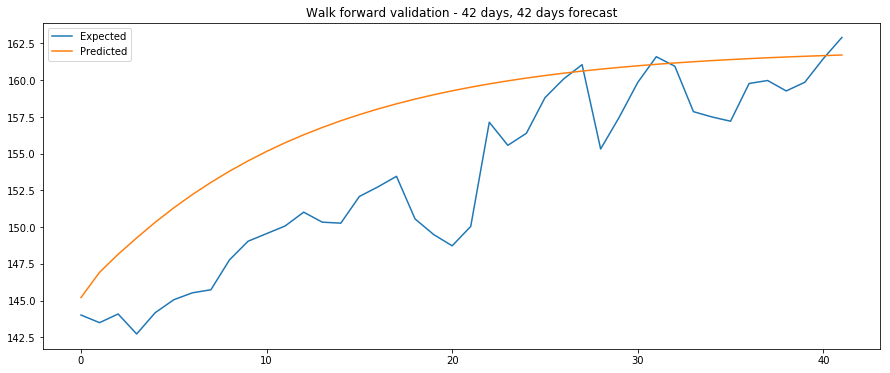

In [36]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [37]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[42 days, 42 day forecast] - RMSE: 5.073


In [38]:
size = 252 # approx. one year
steps = 252 # 252 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.99568999 0.9963963  0.99689424 0.99734187 0.9977659  0.99815381
 0.9985069  0.99882948 0.99912453 0.99939406 0.99964035 0.99986529
 1.00007069 1.00025833 1.00042987 1.00058651 1.00072956 1.00086021
 1.00097954 1.0010885  1.00118804 1.00127876 1.00136173 1.00143754
 1.00150681 1.00156999 1.00162768 1.00168049 1.00172853 1.0017724
 1.00181246 1.00184906 1.00188243 1.00191295 1.00194085 1.00196612
 1.00198936 1.00201058 1.0020299  1.00204766 1.00206375 1.00207853
 1.00209212 1.00210428 1.00211549 1.00212562 1.00213492 1.0021435
 1.00215137 1.0021584  1.00216496 1.00217104 1.0021764  1.00218129
 1.0021857  1.00218976 1.00219357 1.00219703 1.00220013 1.00220299
 1.00220561 1.00220788 1.00221002 1.00221205 1.00221395 1.00221574
 1.00221729 1.00221872 1.00222003 1.00222123 1.0022223  1.00222337
 1.00222421 1.00222504 1.00222576 1.00222635 1.00222695 1.00222766
 1.00222814 1.0022285  1.00222898 1.00222945 1.00222981 1.00223017
 1.00223041 1.00223064 1.00223088 1.00223112 1.0022312

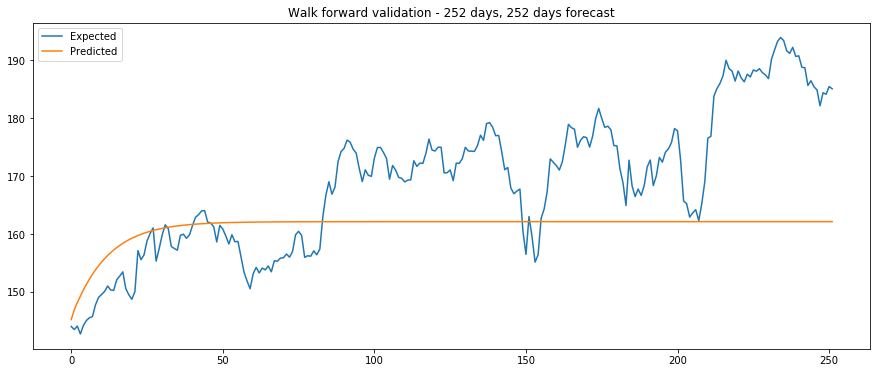

In [39]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [40]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[252 days, 252 day forecast] - RMSE: 13.322
